In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

os.environ["CUDA_VISIBLE_DEVICES"]="3"
IMG_PATH = './/birds/training_images'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
from tqdm import tqdm, trange
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torchvision
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from ignite.metrics import Accuracy
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.manual_seed(42)

In [3]:
NUM_CLASSES = 200

df = pd.read_csv(".//birds/training_labels.txt", sep=' ', names=['img', 'label'])
df[['label_id', 'label_name']] = df['label'].str.split('.', 1, expand=True)
df = df[['img', 'label_id']]
df['label_id'] = df['label_id'].astype('int') - 1
df = list(df.itertuples(index=False, name=None))
train_df, val_df = train_test_split(df, test_size=0.275, random_state=42)

def getClassDistribution(arr):
    res = [0] * NUM_CLASSES
    for fname, label in arr:
        res[label] += 1
    return res

print('Train class distribution', getClassDistribution(train_df))
print('Valid class distribution', getClassDistribution(val_df))

Train class distribution [11, 11, 10, 11, 11, 10, 14, 12, 12, 12, 8, 10, 11, 8, 13, 9, 8, 13, 11, 10, 13, 9, 12, 11, 13, 13, 10, 10, 10, 10, 14, 9, 12, 14, 8, 12, 10, 14, 13, 13, 12, 11, 12, 8, 10, 13, 10, 13, 9, 13, 13, 7, 8, 10, 10, 7, 13, 11, 13, 10, 15, 11, 11, 12, 10, 11, 9, 9, 12, 11, 12, 12, 10, 12, 13, 8, 13, 13, 11, 11, 7, 11, 12, 12, 12, 11, 10, 9, 10, 11, 9, 12, 9, 12, 13, 13, 5, 13, 10, 12, 13, 10, 12, 11, 11, 11, 11, 12, 10, 11, 10, 13, 12, 12, 13, 11, 8, 7, 12, 12, 11, 12, 9, 9, 10, 11, 12, 10, 11, 12, 10, 11, 10, 12, 8, 12, 11, 11, 12, 8, 11, 10, 12, 9, 7, 11, 10, 9, 11, 11, 10, 10, 10, 10, 12, 7, 11, 11, 10, 11, 12, 10, 8, 10, 13, 13, 13, 11, 8, 14, 11, 11, 13, 12, 12, 10, 11, 14, 12, 10, 13, 11, 12, 11, 11, 9, 10, 11, 12, 12, 11, 10, 10, 11, 7, 10, 13, 9, 8, 11]
Valid class distribution [4, 4, 5, 4, 4, 5, 1, 3, 3, 3, 7, 5, 4, 7, 2, 6, 7, 2, 4, 5, 2, 6, 3, 4, 2, 2, 5, 5, 5, 5, 1, 6, 3, 1, 7, 3, 5, 1, 2, 2, 3, 4, 3, 7, 5, 2, 5, 2, 6, 2, 2, 8, 7, 5, 5, 8, 2, 4, 2, 5, 0, 4

In [4]:
class BirdDataset(Dataset):
    def __init__(
        self, df, root_dir, transforms=None, output_label=False
    ):
        super().__init__()
        self.df = df
        self.length = len(df)
        self.transforms = transforms
        self.root_dir = root_dir
        self.output_label = output_label
    
    def __len__(self):
        return self.length
    
    def read_img(self, image_id):
        path_img = os.path.join(self.root_dir, str(image_id))
        img = cv2.imread(path_img)[:,:,::-1]
        return img
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.df[index][1]
        
        img  = self.read_img(self.df[index][0])
        
        if self.transforms:
            img = self.transforms(image=img)['image']
            
        # do label smoothing
        if self.output_label :
            return img, target
        else:
            return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


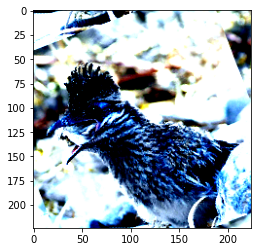

In [5]:
IMG_SIZE = 224 

train_transform = A.Compose([
    A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.75, 1)),
#     A.Resize(475, 475),
#     A.CenterCrop(IMG_SIZE, IMG_SIZE),
    # A.RandomFog(p=0.5, fog_coef_upper=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=1, border_mode=3),
#     A.ElasticTransform(p=1),
    A.RandomBrightnessContrast(p=1),
    A.RandomGamma(p=1),
    A.CoarseDropout(p=0.5),
#     A.CLAHE(p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1),
    ToTensorV2(p=1.0),
])

test_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(IMG_SIZE, IMG_SIZE),
#     A.CLAHE(p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1.0),
    ToTensorV2(p=1.0),
])

train_dataset = BirdDataset(train_df, IMG_PATH, train_transform, output_label=False)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
for img in train_loader:
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [6]:
from loss import CenterLoss
from scheduler import CyclicCosineDecayLR

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 64
NUM_WORKERS = 4

train_dataset = BirdDataset(train_df, IMG_PATH, train_transform, output_label=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataset = BirdDataset(val_df, IMG_PATH, test_transform, output_label=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# model = torch.hub.load('PingoLH/Pytorch-HarDNet', 'hardnet68', pretrained=True)
# model.base[-1][3] = nn.Linear(1024, NUM_CLASSES)
# model.base[-1][2] = nn.Dropout(0.5)

model = torchvision.models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(2048, NUM_CLASSES)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
centerloss = CenterLoss(num_class=NUM_CLASSES, num_feature=NUM_CLASSES).to(device)
alpha = 0.001
optimizer_centloss = torch.optim.SGD(centerloss.parameters(), lr=0.1)

def train_one_epoch():
    model.train()
    losses = []
    metrics = Accuracy()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels) + alpha * centerloss(outputs, labels)
        
        optimizer.zero_grad()
        optimizer_centloss.zero_grad()
        loss.backward()
        optimizer.step()
        for param in centerloss.parameters():
            param.grad.data *= (1./alpha)
        optimizer_centloss.step()
        
        metrics.update((outputs, labels))
        losses.append(loss.item())
    return sum(losses) / len(losses), metrics.compute()

@torch.no_grad()
def evaluate():
    model.eval()
    
    losses = []
    metrics = Accuracy()
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels) + alpha * centerloss(outputs, labels)
        metrics.update((outputs, labels))
        losses.append(loss.item())

    return sum(losses) / len(losses), metrics.compute()

def train_model(epoches):
    history = {'loss': [], 'acc': []}
    tbar = trange(epoches)
    best_acc = 0
    last_loss = 1e9
    patience = 3
    triggered = 0
    for epoch in tbar:
        loss, acc = train_one_epoch()
        val_loss, val_acc = evaluate()

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), './bird-baseline.pth')

        tbar.set_postfix({
            'loss' : loss,
            'acc' : acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })
        
        history['loss'].append(val_loss)
        history['acc'].append(val_acc)
        
        if val_loss > last_loss:
            triggered += 1
            if triggered == patience:
                print('Early stopped!')
                break
        else:
            triggered = 0
        last_loss = val_loss
    return history

cuda


In [8]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False
# except fc
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

history = train_model(150)

 48%|█████████████████▊                   | 72/150 [08:55<09:40,  7.44s/it, loss=1.12, acc=0.916, val_loss=2.59, val_acc=0.472]

Early stopped!


In [9]:
# Unfreeze layer 3, 4
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=1e-4)

history = train_model(150)

 97%|███████████████████████████████████ | 146/150 [18:09<00:29,  7.46s/it, loss=0.18, acc=0.998, val_loss=1.53, val_acc=0.672]

Early stopped!


In [10]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, nesterov=True, weight_decay=1e-4)
# scheduler = CyclicCosineDecayLR(optimizer, 20, 1e-8)

history = train_model(150)

  3%|▉                                    | 4/150 [00:48<29:22, 12.07s/it, loss=0.176, acc=0.999, val_loss=1.52, val_acc=0.673]

Early stopped!


In [11]:
best_acc = 0
for i in range(len(history['loss'])):
    best_acc = max(best_acc, history['acc'][i])
    print('loss: {}, acc: {}'.format(history['loss'][i], history['acc'][i]))
print('Best acc: {}'.format(best_acc))

loss: 1.521390098791856, acc: 0.6646489104116223
loss: 1.5118352174758911, acc: 0.6731234866828087
loss: 1.5159209324763372, acc: 0.6694915254237288
loss: 1.5203205255361705, acc: 0.6670702179176755
loss: 1.5224726566901574, acc: 0.6731234866828087
Best acc: 0.6731234866828087


##### 